In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
import wandb
from torch_lr_finder import LRFinder
from utils import EarlyStopping

In [25]:
run = wandb.init(project='HyperView-initial', reinit=True)
# wandb.init(mode="disabled") # in case of testing code

average_train_MSE_K,█▁▁▁▁
average_train_MSE_Mg,█▁▁▁▁
average_train_MSE_P,█▁▁▁▁
average_train_MSE_pH,█▁▁▁▁
average_train_loss,█▁▁▁▁
average_val_MSE_K,▃▃▁█▄
average_val_MSE_Mh,▁▃▆▆█
average_val_MSE_P,▁▃▃█▇
average_val_MSE_pH,█▁▂▁▁
average_val_loss,▁▃▃█▇
batch_number,▁▃▅▆█▁▃▅▆█▁▃▅▆█▁▃▅▆█▁▃▅▆█


### Paths definition

In [59]:
train_data_directory = r'train_data'
test_data_directory = r'test_data'
saved_models_directory = r'saved_models'
submissions_directory = r'submissions'

### Dataset testing

In [34]:
all_files = np.array(
    sorted(
        glob(os.path.join(train_data_directory, 'train_data', "*.npz")),
        key=lambda x: int(os.path.basename(x).replace(".npz", "")),
    )
)

In [4]:
all_files

array(['train_data/train_data/0.npz', 'train_data/train_data/1.npz',
       'train_data/train_data/2.npz', ...,
       'train_data/train_data/1729.npz', 'train_data/train_data/1730.npz',
       'train_data/train_data/1731.npz'], dtype='<U30')

In [64]:
arr = np.ma.MaskedArray(**np.load(all_files[1454]))
arr.shape

(150, 93, 115)

In [80]:
arr.shape[1], arr.shape[2]

(93, 115)

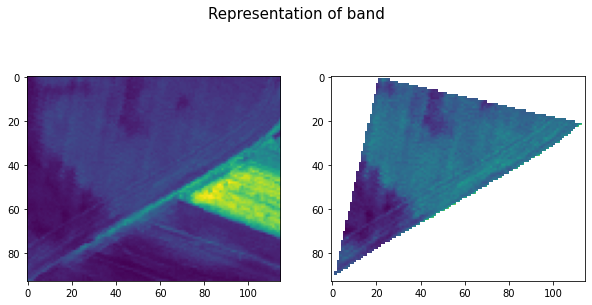

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 145

axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])
plt.suptitle(f'Representation of band', fontsize=15)
plt.show()

In [65]:
tensor_data = torch.as_tensor(arr)
tensor_data

tensor([[[ 275,  268,  279,  ...,  309,  338,  281],
         [ 250,  261,  276,  ...,  357,  336,  365],
         [ 243,  251,  251,  ...,  337,  295,  304],
         ...,
         [ 363,  359,  354,  ...,  268,  275,  268],
         [ 381,  345,  378,  ...,  295,  284,  287],
         [ 398,  428,  424,  ...,  297,  296,  318]],

        [[ 271,  270,  274,  ...,  308,  342,  283],
         [ 255,  262,  277,  ...,  357,  338,  372],
         [ 250,  251,  250,  ...,  338,  295,  301],
         ...,
         [ 366,  359,  360,  ...,  264,  269,  265],
         [ 377,  351,  384,  ...,  296,  283,  288],
         [ 402,  434,  433,  ...,  296,  302,  315]],

        [[ 266,  267,  264,  ...,  299,  341,  280],
         [ 254,  261,  275,  ...,  353,  331,  375],
         [ 251,  246,  249,  ...,  334,  289,  302],
         ...,
         [ 365,  356,  357,  ...,  258,  266,  257],
         [ 378,  348,  380,  ...,  292,  279,  284],
         [ 403,  432,  427,  ...,  296,  299,  319]],

In [66]:
tensor_data.shape

torch.Size([150, 93, 115])

In [67]:
tensor_mask_bool = torch.as_tensor(arr.mask)
tensor_mask_bool

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True, False, False,  ...,  True,  True,  True],
         [ True, False,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True, False, False,  ...,  True,  True,  True],
         [ True, False,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True, False, False,  ...,  True,  True,  True],
         [

In [73]:
tensor_mask_bool.shape

torch.Size([150, 93, 115])

In [177]:
tensor_data_masked = torch.mul(tensor_data, tensor_mask_bool)
tensor_data_masked

tensor([[[ 275,  268,  279,  ...,  309,  338,  281],
         [ 250,  261,  276,  ...,  357,  336,  365],
         [ 243,  251,  251,  ...,  337,  295,  304],
         ...,
         [ 363,    0,    0,  ...,  268,  275,  268],
         [ 381,    0,  378,  ...,  295,  284,  287],
         [ 398,  428,  424,  ...,  297,  296,  318]],

        [[ 271,  270,  274,  ...,  308,  342,  283],
         [ 255,  262,  277,  ...,  357,  338,  372],
         [ 250,  251,  250,  ...,  338,  295,  301],
         ...,
         [ 366,    0,    0,  ...,  264,  269,  265],
         [ 377,    0,  384,  ...,  296,  283,  288],
         [ 402,  434,  433,  ...,  296,  302,  315]],

        [[ 266,  267,  264,  ...,  299,  341,  280],
         [ 254,  261,  275,  ...,  353,  331,  375],
         [ 251,  246,  249,  ...,  334,  289,  302],
         ...,
         [ 365,    0,    0,  ...,  258,  266,  257],
         [ 378,    0,  380,  ...,  292,  279,  284],
         [ 403,  432,  427,  ...,  296,  299,  319]],

In [178]:
tensor_data_masked.shape

torch.Size([150, 93, 115])

In [285]:
def pad_to_minimum_size(min_size, image):
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2
        print(h_diff, w_diff)
        
        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)
        
        print(h_pad1, h_pad2, w_pad1, w_pad2)
        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)
    

In [286]:
pad_to_minimum_size(300, tensor_data_masked).shape

103.5 92.5
103 104 92 93


torch.Size([150, 300, 300])

### Load mean and std values of training dataset

In [5]:
means_stds_arrays = np.load(os.path.join(train_data_directory, 'means_stds_values_training_data.npz'))
means = np.array(means_stds_arrays['means'])
stds = np.array(means_stds_arrays['stds'])

In [425]:
tensor_data_masked_normalized = transforms.functional.normalize(torch.as_tensor(tensor_data_masked, dtype=torch.float), mean=means.tolist(), std=stds.tolist())
tensor_data_masked_normalized

tensor([[[-2.7990e+00, -2.9844e+00, -2.6931e+00,  ..., -1.8987e+00,
          -1.1307e+00, -2.6401e+00],
         [-3.4611e+00, -3.1698e+00, -2.7725e+00,  ..., -6.2756e-01,
          -1.1837e+00, -4.1570e-01],
         [-3.6464e+00, -3.4346e+00, -3.4346e+00,  ..., -1.1572e+00,
          -2.2694e+00, -2.0311e+00],
         ...,
         [-4.6867e-01, -1.0081e+01, -1.0081e+01,  ..., -2.9844e+00,
          -2.7990e+00, -2.9844e+00],
         [ 7.9982e-03, -1.0081e+01, -7.1446e-02,  ..., -2.2694e+00,
          -2.5607e+00, -2.4813e+00],
         [ 4.5818e-01,  1.2526e+00,  1.1467e+00,  ..., -2.2164e+00,
          -2.2429e+00, -1.6603e+00]],

        [[-2.8853e+00, -2.9117e+00, -2.8061e+00,  ..., -1.9079e+00,
          -1.0096e+00, -2.5683e+00],
         [-3.3080e+00, -3.1231e+00, -2.7268e+00,  ..., -6.1338e-01,
          -1.1153e+00, -2.1711e-01],
         [-3.4401e+00, -3.4137e+00, -3.4401e+00,  ..., -1.1153e+00,
          -2.2513e+00, -2.0928e+00],
         ...,
         [-3.7562e-01, -1

In [20]:
temp_gt = pd.read_csv(os.path.join(train_data_directory, 'train_gt.csv'))[['P','K','Mg','pH']]

In [22]:
temp_gt

,P,K,Mg,pH
0,45.1,188.0,179.0,7.2
1,44.8,205.0,188.0,7.0
2,44.4,207.0,145.0,6.8
3,46.5,204.0,143.0,6.8
4,52.0,212.0,167.0,6.7
...,...,...,...,...
1727,40.8,133.0,132.0,6.2
1728,42.7,192.0,126.0,6.5
1729,39.4,180.0,122.0,6.5
1730,37.3,162.0,127.0,6.5


In [25]:
temp_gt.loc[1, 'P']

44.8

### Dataset definition

In [36]:
class HyperViewDataset(Dataset):
    def __init__(self, gt_file, img_dir, transform=None, means=None, stds=None):
        self.img_dir = img_dir
        if gt_file is not None:
            self.gt = pd.read_csv(gt_file)[['P','K','Mg','pH']]
        else:
            self.gt = None
        self.transform = transform # whether to perform transformation of input data
        self.means = means # mean values for every band used to normalize data
        self.stds = stds # std values for every band used to normalize data
        
        self.img_files = np.array(
            sorted(
                glob(os.path.join(img_dir, "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )
    
    def pad_to_minimum_size(self, min_size, image):
        # pads numpy array to defined in `min_size` minimum size of array (w, h)
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2
        
        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)
        
        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        # load hyperspectral image to array
        img_arr = np.ma.MaskedArray(**np.load(self.img_files[idx]))
        img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float)
        img_tensor_mask = torch.as_tensor(img_arr.mask)
        img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)
        
        if self.transform:
            img_masked_tensor_normalized = transforms.functional.normalize(img_masked_tensor, mean=self.means.tolist(), std=self.stds.tolist())
            img_masked_tensor_normalized_padded = self.pad_to_minimum_size(300, img_masked_tensor_normalized)
            img_result_tensor = img_masked_tensor_normalized_padded
        else:
            img_result_tensor = img_masked_tensor
        # load labels
        if self.gt is not None:
            P_gt = self.gt.loc[idx, 'P']
            K_gt = self.gt.loc[idx, 'K']
            Mg_gt = self.gt.loc[idx, 'Mg']
            pH_gt = self.gt.loc[idx, 'pH']

            sample = {'image': img_result_tensor, 'P': P_gt, 'K': K_gt, 'Mg': Mg_gt, 'pH': pH_gt}
        else:
            sample = {'image': img_result_tensor}
        
        return sample

In [37]:
train_data_whole = HyperViewDataset(os.path.join(train_data_directory, 'train_gt.csv'), os.path.join(train_data_directory, 'train_data'), True, means, stds)

In [38]:
train_dataset, validation_dataset = random_split(train_data_whole, [1400, 332])

### Model Definition

In [9]:
from torchvision import datasets, models, transforms

In [10]:
class ResNetCNN(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        self.resnet_model = models.resnet34(pretrained=False)
        
        self.resnet_model.conv1 = nn.Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet_model.fc = nn.Linear(512, 4, bias=True)
        
    def forward(self, x):
        x = self.resnet_model(x)
#         return {'P': x[0], 'K': x[1], 'Mg': x[2], 'pH': x[3]}
        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [24]:
BATCH_SIZE = 12
EPOCHS = 300

In [28]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=2)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=2)

### Overfitting on single batch of data

In [19]:
train_data_single_batch = next(iter(train_dataloader))

In [20]:
train_data_single_batch

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

In [21]:
train_data_single_batch['image'][0].shape

torch.Size([150, 300, 300])

In [463]:
train_data_single_batch['image'].to(device, dtype=torch.float).shape

torch.Size([8, 150, 300, 300])

In [464]:
output = modelResNetCNN(train_data_single_batch['image'].to(device, dtype=torch.float))

In [465]:
output

tensor([[ 77.9738, 298.0117, 173.9782,   6.5970],
        [ 64.6926, 165.9923, 151.9960,   6.5672],
        [ 25.0137, 247.9812, 171.0289,   6.5973],
        [ 37.6087, 191.0036, 152.9605,   6.7541],
        [101.0079, 308.9837, 152.0241,   6.8512],
        [ 82.3947, 232.9995, 161.9893,   6.8195],
        [121.0051, 241.9958,  57.0968,   7.0230],
        [ 78.8475, 189.9610,  81.0190,   6.7596]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [466]:
stacked_gt = torch.stack((train_data_single_batch['P'], train_data_single_batch['K'], train_data_single_batch['Mg'], train_data_single_batch['pH']))
stacked_gt

tensor([[ 78.0000,  64.7000,  25.0000,  37.6000, 101.0000,  82.4000, 121.0000,
          78.8000],
        [298.0000, 166.0000, 248.0000, 191.0000, 309.0000, 233.0000, 242.0000,
         190.0000],
        [174.0000, 152.0000, 171.0000, 153.0000, 152.0000, 162.0000,  57.1000,
          81.0000],
        [  6.4000,   6.6000,   6.7000,   6.6000,   7.0000,   6.8000,   6.8300,
           7.1000]], dtype=torch.float64)

In [467]:
stacked_gt = stacked_gt.transpose(0, 1).to(device)

In [468]:
stacked_gt

tensor([[ 78.0000, 298.0000, 174.0000,   6.4000],
        [ 64.7000, 166.0000, 152.0000,   6.6000],
        [ 25.0000, 248.0000, 171.0000,   6.7000],
        [ 37.6000, 191.0000, 153.0000,   6.6000],
        [101.0000, 309.0000, 152.0000,   7.0000],
        [ 82.4000, 233.0000, 162.0000,   6.8000],
        [121.0000, 242.0000,  57.1000,   6.8300],
        [ 78.8000, 190.0000,  81.0000,   7.1000]], device='cuda:0',
       dtype=torch.float64)

In [469]:
loss_func(output, stacked_gt)

tensor(0.0081, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

In [22]:
img_data_device = train_data_single_batch['image'].to(device, dtype=torch.float)
stacked_gt_device = torch.stack((train_data_single_batch['P'], train_data_single_batch['K'], train_data_single_batch['Mg'], train_data_single_batch['pH'])).transpose(0,1).to(device, 
    dtype=torch.float)

modelResNetCNN = ResNetCNN(False).to(device)
optimizer = torch.optim.AdamW(modelResNetCNN.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

for epoch in range(300):
    modelResNetCNN.train()
    
    output = modelResNetCNN(img_data_device)
    loss = loss_func(output, stacked_gt_device)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    output_cpu = output.detach().cpu().numpy()
    stacked_gt_cpu = stacked_gt_device.cpu().numpy()

    # Calculate MSE for each class
    mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
    
    if epoch%10 == 0:
        print(f'epoch: {epoch}, loss: {loss.data.cpu().numpy()}, MSE: {mse}')

epoch: 0, loss: 25068.59375, MSE: [5.1818486e+03 7.3724484e+04 2.1317166e+04 5.0878441e+01]
epoch: 10, loss: 8498.189453125, MSE: [9.9344537e+02 3.0511973e+04 2.4821572e+03 5.1810579e+00]
epoch: 20, loss: 1943.198486328125, MSE: [ 560.27057  3929.0535   3276.4155      7.054283]
epoch: 30, loss: 929.8078002929688, MSE: [ 612.38464  1902.7195   1200.2067      3.920496]
epoch: 40, loss: 2129.715576171875, MSE: [7.9544196e+02 6.6813291e+03 1.0411436e+03 9.4775909e-01]
epoch: 50, loss: 625.610595703125, MSE: [4.2386243e+02 1.0506796e+03 1.0277257e+03 1.7471790e-01]
epoch: 60, loss: 330.2525634765625, MSE: [2.7662155e+02 2.1674701e+02 8.2739667e+02 2.4512239e-01]
epoch: 70, loss: 231.21075439453125, MSE: [2.4271884e+02 9.6238701e+01 5.8572644e+02 1.5911290e-01]
epoch: 80, loss: 211.90435791015625, MSE: [2.5378592e+02 7.1360870e+01 5.2231055e+02 1.6007546e-01]
epoch: 90, loss: 199.3742218017578, MSE: [2.3856584e+02 6.5869728e+01 4.9299261e+02 6.8759516e-02]
epoch: 100, loss: 190.6460266113281

### Training

In [29]:
model_name = 'Resnet34_BATCHSIZE_12_AdamW_LR_0_0179_ReduceLROnPlateau_Factor0_2_Threshold_0_0001'

In [30]:
modelResNetCNN = ResNetCNN(False).to(device)

In [31]:
wandb.watch(modelResNetCNN, log="None", log_freq=20)

[]

In [32]:
optimizer = torch.optim.AdamW(modelResNetCNN.parameters(), lr=0.0179)

In [33]:
loss_func = torch.nn.MSELoss()

#### Find LR

In [27]:
from torch_lr_finder.lr_finder import TrainDataLoaderIter

In [28]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return (torch.as_tensor(batch_data['image'], dtype=torch.float), 
                torch.as_tensor(torch.stack((batch_data['P'], batch_data['K'], batch_data['Mg'], batch_data['pH'])).transpose(0,1), dtype=torch.float))

In [29]:
lr_finder = LRFinder(modelResNetCNN, optimizer, loss_func, device=device)
lr_finder.range_test(CustomTrainIter(train_dataloader), start_lr=0.00001, end_lr=100, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.79E-02


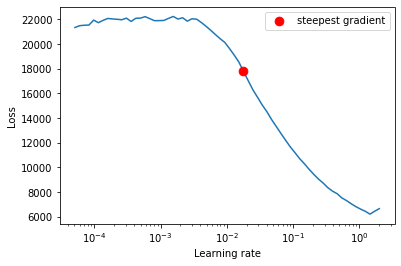

In [30]:
lr_finder.plot()
lr_finder.reset()

#### Continue training

In [34]:
patience_scheduler_overfit = 6
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                       factor=0.2, patience = patience_scheduler_overfit,
                                                       threshold=0.0001, threshold_mode='abs')

In [35]:
early_stopping = EarlyStopping(patience=(2*patience_scheduler_overfit)+3, verbose=True,
                               path=os.path.join(saved_models_directory, 'checkpoint_state_dict.pth'))

In [36]:
config = wandb.config
config.optimizer =  'AdamW'
config.learning_rate_start = optimizer.param_groups[0]["lr"]
# config.momentum = optimizer.param_groups[0]["momentum"]
config.momentum = None
config.weight_decay = optimizer.param_groups[0]["weight_decay"]
config.scheduler =  'ReduceLROnPlateau'
config.scheduler_factor =  0.2
config.scheduler_patience =  5
config.scheduler_threshold =  0.0001
config.batch_size = BATCH_SIZE

In [37]:
previous_epochs = 0 # how many epochs have been done previously if resuming

In [38]:
for epoch in range(previous_epochs, EPOCHS+previous_epochs):
    # TRAINING Part
    modelResNetCNN.train()
    train_loss = []
    mse_train_list = []
    
    bar = tqdm(train_dataloader, position=0, leave=False, desc=f'epoch {epoch} training data')
    i = 0
    for train_data in bar: # for each training step
        i += 1
        img_data_device = train_data['image'].to(device, dtype=torch.float)
        stacked_gt_device = torch.stack((train_data['P'], train_data['K'], train_data['Mg'], train_data['pH'])).transpose(0,1).to(device, dtype=torch.float)
        
        output = modelResNetCNN(img_data_device)
        
        loss = loss_func(output, stacked_gt_device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)
        
        output_cpu = output.detach().cpu().numpy()
        stacked_gt_cpu = stacked_gt_device.cpu().numpy()
        
        # Calculate MSE for each class
        mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
        mse_train_list.append(mse)
        
        if i % 10 == 0: # log every 10 batches
            train_log_dict = dict()
            train_log_dict['batch_number'] = i
            train_log_dict['epoch'] = epoch
            train_log_dict['train_batch_loss'] = loss 
            train_log_dict['train_batch_MSE_P'] = mse[0]
            train_log_dict['train_batch_MSE_K'] = mse[1]
            train_log_dict['train_batch_MSE_Mg'] = mse[2]
            train_log_dict['train_batch_MSE_pH'] = mse[3]
            wandb.log(train_log_dict)
    
    avg_train_loss = torch.stack(train_loss).mean().item()
    avg_train_mse = torch.as_tensor(np.array(mse_train_list)).mean(axis=0).numpy().tolist()
    
    print(f'epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}, train loss: {avg_train_loss}, train MSE: {avg_train_mse}')
    wandb.log({'epoch': epoch, 'average_train_loss':avg_train_loss, 'average_train_MSE_P': avg_train_mse[0], 'average_train_MSE_K': avg_train_mse[1],
              'average_train_MSE_Mg': avg_train_mse[2], 'average_train_MSE_pH': avg_train_mse[3]})
    
    # VALIDATION Part
    modelResNetCNN.eval()
    val_bar = tqdm(validation_dataloader, position=0, leave=False, desc=f'epoch {epoch} validation data')
    with torch.no_grad():
        val_loss = []
        mse_val_list = []
        for val_data in val_bar:
            img_data_device = val_data['image'].to(device, dtype=torch.float)
            stacked_gt_device = torch.stack((val_data['P'], val_data['K'], val_data['Mg'], val_data['pH'])).transpose(0,1).to(device, dtype=torch.float)
            
            output = modelResNetCNN(img_data_device)
            
            loss = loss_func(output, stacked_gt_device)
            val_loss.append(loss)
            
            output_cpu = output.detach().cpu().numpy()
            stacked_gt_cpu = stacked_gt_device.cpu().numpy()

            # Calculate MSE for each class
            mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
            mse_val_list.append(mse)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        avg_val_mse = torch.as_tensor(np.array(mse_val_list)).mean(axis=0).numpy().tolist()
        
        print(f'epoch: {epoch}, validation loss: {avg_val_loss}, validation MSE: {avg_val_mse}')
        wandb.log({'epoch': epoch, 'average_val_loss': avg_val_loss, 'average_val_MSE_P': avg_val_mse[0], 'average_val_MSE_K': avg_val_mse[1], 
                   'average_val_MSE_Mh': avg_val_mse[2], 'average_val_MSE_pH': avg_val_mse[3]})
        
        scheduler.step(avg_val_loss)
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, modelResNetCNN)

        if early_stopping.early_stop:
            print("Early stopping")
            break


epoch 0 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 0, LR: 0.0179, train loss: 2543.665283203125, train MSE: [1117.4708251953125, 6291.53515625, 2761.7353515625, 3.921243906021118]


epoch 0 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 0, validation loss: 1609.790771484375, validation MSE: [1096.86572265625, 3584.8642578125, 1757.2911376953125, 0.1418648362159729]
Validation loss decreased (inf --> 1609.790771).  Saving model ...


epoch 1 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 1, LR: 0.0179, train loss: 1627.10107421875, train MSE: [864.2564086914062, 4050.583251953125, 1593.4000244140625, 0.16381625831127167]


epoch 1 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 1, validation loss: 1652.1064453125, validation MSE: [1111.7388916015625, 3752.7373046875, 1742.953125, 0.9961733222007751]
EarlyStopping counter: 1 out of 15


epoch 2 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 2, LR: 0.0179, train loss: 1624.78857421875, train MSE: [874.4116821289062, 4036.84326171875, 1587.677978515625, 0.22042514383792877]


epoch 2 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 2, validation loss: 1750.577880859375, validation MSE: [1143.41552734375, 4061.617431640625, 1796.7227783203125, 0.555298388004303]
EarlyStopping counter: 2 out of 15


epoch 3 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 3, LR: 0.0179, train loss: 1626.9119873046875, train MSE: [873.525146484375, 4038.140869140625, 1595.7333984375, 0.24868234992027283]


epoch 3 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 3, validation loss: 1605.7213134765625, validation MSE: [1099.416259765625, 3672.192626953125, 1649.875732421875, 1.4007481336593628]
Validation loss decreased (1609.790771 --> 1605.721313).  Saving model ...


epoch 4 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 4, LR: 0.0179, train loss: 1624.6395263671875, train MSE: [871.4733276367188, 4021.185302734375, 1605.675537109375, 0.22355757653713226]


epoch 4 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 4, validation loss: 1654.42626953125, validation MSE: [1109.3717041015625, 3753.942138671875, 1753.9071044921875, 0.4834617078304291]
EarlyStopping counter: 1 out of 15


epoch 5 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 5, LR: 0.0179, train loss: 1623.6700439453125, train MSE: [871.18896484375, 4027.338134765625, 1595.9521484375, 0.20048488676548004]


epoch 5 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 5, validation loss: 1920.0098876953125, validation MSE: [1188.9385986328125, 4633.43359375, 1857.4520263671875, 0.21513155102729797]
EarlyStopping counter: 2 out of 15


epoch 6 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 6, LR: 0.0179, train loss: 1612.9154052734375, train MSE: [870.8483276367188, 3988.13427734375, 1592.464599609375, 0.21426349878311157]


epoch 6 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 6, validation loss: 1617.539306640625, validation MSE: [1134.2816162109375, 3567.223876953125, 1768.537353515625, 0.11447831988334656]
EarlyStopping counter: 3 out of 15


epoch 7 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 7, LR: 0.0179, train loss: 1612.5693359375, train MSE: [873.623046875, 3982.28125, 1594.125732421875, 0.24681617319583893]


epoch 7 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 7, validation loss: 1955.140380859375, validation MSE: [1166.0545654296875, 4858.2509765625, 1796.0994873046875, 0.15585185587406158]
EarlyStopping counter: 4 out of 15


epoch 8 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 8, LR: 0.0179, train loss: 1624.174560546875, train MSE: [866.2962036132812, 4044.68994140625, 1585.4896240234375, 0.22234126925468445]


epoch 8 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 8, validation loss: 1701.97119140625, validation MSE: [1125.6724853515625, 3894.16455078125, 1787.9776611328125, 0.0702156350016594]
EarlyStopping counter: 5 out of 15


epoch 9 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 9, LR: 0.0179, train loss: 1618.6654052734375, train MSE: [869.5302124023438, 4006.05810546875, 1598.83984375, 0.23315784335136414]


epoch 9 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 9, validation loss: 1580.1754150390625, validation MSE: [1090.968994140625, 3565.799072265625, 1663.5787353515625, 0.354067862033844]
Validation loss decreased (1605.721313 --> 1580.175415).  Saving model ...


epoch 10 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 10, LR: 0.0179, train loss: 1605.9420166015625, train MSE: [866.803466796875, 3969.00732421875, 1587.7520751953125, 0.20529073476791382]


epoch 10 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 10, validation loss: 1662.6793212890625, validation MSE: [1117.20458984375, 3867.391845703125, 1665.720947265625, 0.3990301489830017]
EarlyStopping counter: 1 out of 15


epoch 11 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 11, LR: 0.0179, train loss: 1603.8912353515625, train MSE: [863.9996337890625, 3964.861083984375, 1586.49853515625, 0.2061401903629303]


epoch 11 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 11, validation loss: 1594.2222900390625, validation MSE: [1096.103759765625, 3629.704345703125, 1650.576416015625, 0.5043301582336426]
EarlyStopping counter: 2 out of 15


epoch 12 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 12, LR: 0.0179, train loss: 1617.092529296875, train MSE: [867.6895751953125, 4013.431884765625, 1587.0701904296875, 0.17810457944869995]


epoch 12 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 12, validation loss: 1628.784423828125, validation MSE: [1095.546142578125, 3685.0302734375, 1734.3179931640625, 0.24264632165431976]
EarlyStopping counter: 3 out of 15


epoch 13 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 13, LR: 0.0179, train loss: 1609.576904296875, train MSE: [862.9016723632812, 3975.0078125, 1600.20556640625, 0.1921859234571457]


epoch 13 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 13, validation loss: 1744.290771484375, validation MSE: [1122.9365234375, 4117.80126953125, 1735.9932861328125, 0.43140891194343567]
EarlyStopping counter: 4 out of 15


epoch 14 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 14, LR: 0.0179, train loss: 1609.53759765625, train MSE: [862.338134765625, 3977.549560546875, 1598.065185546875, 0.19738441705703735]


epoch 14 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 14, validation loss: 1610.3304443359375, validation MSE: [1085.0126953125, 3488.09521484375, 1867.7342529296875, 0.47960928082466125]
EarlyStopping counter: 5 out of 15


epoch 15 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 15, LR: 0.0179, train loss: 1605.9737548828125, train MSE: [859.4620971679688, 3962.08251953125, 1602.15771484375, 0.19285184144973755]


epoch 15 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 15, validation loss: 1631.4635009765625, validation MSE: [1110.4541015625, 3695.511962890625, 1719.6627197265625, 0.22578974068164825]
EarlyStopping counter: 6 out of 15


epoch 16 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 16, LR: 0.0179, train loss: 1597.708251953125, train MSE: [858.6156616210938, 3935.79345703125, 1596.240966796875, 0.18251118063926697]


epoch 16 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 16, validation loss: 1808.7850341796875, validation MSE: [1102.560791015625, 3473.722900390625, 2658.5625, 0.29307615756988525]
EarlyStopping counter: 7 out of 15


epoch 17 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 17, LR: 0.00358, train loss: 1529.911865234375, train MSE: [823.5535888671875, 3749.190673828125, 1546.822509765625, 0.08066480606794357]


epoch 17 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 17, validation loss: 1527.9324951171875, validation MSE: [1093.2117919921875, 3344.385498046875, 1674.0645751953125, 0.06798665970563889]
Validation loss decreased (1580.175415 --> 1527.932495).  Saving model ...


epoch 18 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 18, LR: 0.00358, train loss: 1498.0858154296875, train MSE: [819.95263671875, 3636.671142578125, 1535.634033203125, 0.08535894006490707]


epoch 18 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 18, validation loss: 1519.0640869140625, validation MSE: [1094.5938720703125, 3321.088623046875, 1660.50439453125, 0.06955524533987045]
Validation loss decreased (1527.932495 --> 1519.064087).  Saving model ...


epoch 19 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 19, LR: 0.00358, train loss: 1477.286865234375, train MSE: [818.3132934570312, 3568.632568359375, 1522.108642578125, 0.09268929064273834]


epoch 19 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 19, validation loss: 1515.1649169921875, validation MSE: [1093.797119140625, 3312.064208984375, 1654.72119140625, 0.0767182782292366]
Validation loss decreased (1519.064087 --> 1515.164917).  Saving model ...


epoch 20 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 20, LR: 0.00358, train loss: 1463.054931640625, train MSE: [816.667724609375, 3521.415771484375, 1514.044677734375, 0.09115003794431686]


epoch 20 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 20, validation loss: 1635.2149658203125, validation MSE: [1104.0548095703125, 3670.3544921875, 1766.3653564453125, 0.08487127721309662]
EarlyStopping counter: 1 out of 15


epoch 21 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 21, LR: 0.00358, train loss: 1442.361572265625, train MSE: [814.238525390625, 3447.0966796875, 1508.01904296875, 0.09162641316652298]


epoch 21 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 21, validation loss: 1502.5133056640625, validation MSE: [1102.75830078125, 3282.792236328125, 1624.4210205078125, 0.08159943670034409]
Validation loss decreased (1515.164917 --> 1502.513306).  Saving model ...


epoch 22 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 22, LR: 0.00358, train loss: 1432.73193359375, train MSE: [814.3631591796875, 3412.73193359375, 1503.73974609375, 0.09272719919681549]


epoch 22 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 22, validation loss: 1647.830078125, validation MSE: [1117.4063720703125, 3823.5751953125, 1650.228759765625, 0.10870388150215149]
EarlyStopping counter: 1 out of 15


epoch 23 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 23, LR: 0.00358, train loss: 1414.448486328125, train MSE: [812.4243774414062, 3340.970947265625, 1504.303466796875, 0.0954226404428482]


epoch 23 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 23, validation loss: 1608.1649169921875, validation MSE: [1113.3602294921875, 3693.364013671875, 1625.796630859375, 0.13907934725284576]
EarlyStopping counter: 2 out of 15


epoch 24 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 24, LR: 0.00358, train loss: 1401.2095947265625, train MSE: [812.495361328125, 3289.15966796875, 1503.08837890625, 0.09468946605920792]


epoch 24 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 24, validation loss: 1467.250732421875, validation MSE: [1095.625732421875, 3101.195068359375, 1672.1036376953125, 0.078031025826931]
Validation loss decreased (1502.513306 --> 1467.250732).  Saving model ...


epoch 25 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 25, LR: 0.00358, train loss: 1388.7127685546875, train MSE: [812.3182983398438, 3244.448974609375, 1497.991943359375, 0.09236357361078262]


epoch 25 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 25, validation loss: 1459.6031494140625, validation MSE: [1099.9100341796875, 3106.049072265625, 1632.3607177734375, 0.09244083613157272]
Validation loss decreased (1467.250732 --> 1459.603149).  Saving model ...


epoch 26 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 26, LR: 0.00358, train loss: 1380.552001953125, train MSE: [811.5904541015625, 3214.06787109375, 1496.4560546875, 0.09287381172180176]


epoch 26 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 26, validation loss: 1533.1973876953125, validation MSE: [1117.644775390625, 3397.8857421875, 1617.08544921875, 0.17291663587093353]
EarlyStopping counter: 1 out of 15


epoch 27 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 27, LR: 0.00358, train loss: 1371.6546630859375, train MSE: [811.0831909179688, 3178.042236328125, 1497.400146484375, 0.09316042065620422]


epoch 27 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 27, validation loss: 1777.50146484375, validation MSE: [1147.940185546875, 4323.80615234375, 1638.037353515625, 0.22154048085212708]
EarlyStopping counter: 2 out of 15


epoch 28 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 28, LR: 0.00358, train loss: 1354.9888916015625, train MSE: [808.3138427734375, 3119.47900390625, 1492.07373046875, 0.08926139771938324]


epoch 28 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 28, validation loss: 1513.2520751953125, validation MSE: [1111.0870361328125, 3327.769775390625, 1614.0419921875, 0.10942992568016052]
EarlyStopping counter: 3 out of 15


epoch 29 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 29, LR: 0.00358, train loss: 1342.7772216796875, train MSE: [805.06494140625, 3073.1474609375, 1492.8065185546875, 0.08957268297672272]


epoch 29 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 29, validation loss: 1597.2174072265625, validation MSE: [1105.140869140625, 3673.867431640625, 1609.7791748046875, 0.08220135420560837]
EarlyStopping counter: 4 out of 15


epoch 30 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 30, LR: 0.00358, train loss: 1327.2191162109375, train MSE: [804.4993896484375, 3014.304443359375, 1489.981689453125, 0.09080730378627777]


epoch 30 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 30, validation loss: 1568.3270263671875, validation MSE: [1103.7271728515625, 3554.3759765625, 1615.1217041015625, 0.08311347663402557]
EarlyStopping counter: 5 out of 15


epoch 31 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 31, LR: 0.00358, train loss: 1317.5537109375, train MSE: [803.2417602539062, 2975.99072265625, 1490.8897705078125, 0.0923711284995079]


epoch 31 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 31, validation loss: 1551.751708984375, validation MSE: [1106.2236328125, 3485.617431640625, 1615.0806884765625, 0.08451777696609497]
EarlyStopping counter: 6 out of 15


epoch 32 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 32, LR: 0.00358, train loss: 1306.3316650390625, train MSE: [803.5431518554688, 2933.095703125, 1488.590087890625, 0.09776849299669266]


epoch 32 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 32, validation loss: 1651.452880859375, validation MSE: [1112.215087890625, 3859.983154296875, 1633.509521484375, 0.1030815914273262]
EarlyStopping counter: 7 out of 15


epoch 33 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 33, LR: 0.0007160000000000001, train loss: 1253.214599609375, train MSE: [790.1558837890625, 2741.474853515625, 1481.1536865234375, 0.07347960025072098]


epoch 33 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 33, validation loss: 1469.05712890625, validation MSE: [1098.46142578125, 3154.3818359375, 1623.321044921875, 0.06403004378080368]
EarlyStopping counter: 8 out of 15


epoch 34 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 34, LR: 0.0007160000000000001, train loss: 1235.0843505859375, train MSE: [788.0333862304688, 2676.841064453125, 1475.3919677734375, 0.07090088725090027]


epoch 34 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 34, validation loss: 1477.0567626953125, validation MSE: [1100.438720703125, 3186.88427734375, 1620.83935546875, 0.06423426419496536]
EarlyStopping counter: 9 out of 15


epoch 35 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 35, LR: 0.0007160000000000001, train loss: 1222.9093017578125, train MSE: [785.858154296875, 2630.511962890625, 1475.1961669921875, 0.0713152065873146]


epoch 35 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 35, validation loss: 1475.1680908203125, validation MSE: [1100.3319091796875, 3182.742431640625, 1617.533447265625, 0.06449800729751587]
EarlyStopping counter: 10 out of 15


epoch 36 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 36, LR: 0.0007160000000000001, train loss: 1211.56640625, train MSE: [784.1121215820312, 2588.050048828125, 1474.03125, 0.07180097699165344]


epoch 36 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 36, validation loss: 1474.0504150390625, validation MSE: [1101.2281494140625, 3180.26513671875, 1614.6434326171875, 0.06474991142749786]
EarlyStopping counter: 11 out of 15


epoch 37 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 37, LR: 0.0007160000000000001, train loss: 1201.4591064453125, train MSE: [782.50927734375, 2549.765869140625, 1473.48876953125, 0.07216258347034454]


epoch 37 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 37, validation loss: 1473.52978515625, validation MSE: [1101.991943359375, 3180.41748046875, 1611.6446533203125, 0.06495633721351624]
EarlyStopping counter: 12 out of 15


epoch 38 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 38, LR: 0.0007160000000000001, train loss: 1191.4744873046875, train MSE: [780.7930908203125, 2512.12255859375, 1472.9102783203125, 0.07232020795345306]


epoch 38 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 38, validation loss: 1476.0126953125, validation MSE: [1103.14013671875, 3190.636474609375, 1610.209228515625, 0.06520507484674454]
EarlyStopping counter: 13 out of 15


epoch 39 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 39, LR: 0.0007160000000000001, train loss: 1182.359619140625, train MSE: [779.2562866210938, 2477.932861328125, 1472.1766357421875, 0.07236048579216003]


epoch 39 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 39, validation loss: 1473.6728515625, validation MSE: [1103.677978515625, 3183.466796875, 1607.4818115234375, 0.06550506502389908]
EarlyStopping counter: 14 out of 15


epoch 40 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 40, LR: 0.0001432, train loss: 1173.239501953125, train MSE: [776.2185668945312, 2449.751708984375, 1466.9222412109375, 0.06477794051170349]


epoch 40 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 40, validation loss: 1487.535400390625, validation MSE: [1099.2901611328125, 3240.614013671875, 1610.1712646484375, 0.06619714945554733]
EarlyStopping counter: 15 out of 15
Early stopping


In [39]:
torch.save(modelResNetCNN.state_dict(), os.path.join(saved_models_directory, model_name+f'_EPOCHS_{epoch}.pth'))

In [13]:
# load saved model
modelResNetCNNLoad = ResNetCNN(False)
modelResNetCNNLoad.load_state_dict(torch.load(os.path.join(saved_models_directory, 'Resnet34_BATCHSIZE_12_AdamW_LR_0_0179_ReduceLROnPlateau_Factor0_2_Threshold_0_0001_EPOCHS_40.pth')))

<All keys matched successfully>

In [14]:
modelResNetCNNLoad = modelResNetCNNLoad.to(device)

### Predict test dataset

In [15]:
modelResNetCNNLoad.eval()

ResNetCNN(
  (resnet_model): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [53]:
test_data = HyperViewDataset(None, os.path.join(test_data_directory), True, means, stds)

In [54]:
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True, drop_last=False, num_workers=2)

In [55]:
len(test_data)

1154

In [56]:
output_list = []
bar = tqdm(test_dataloader, position=0, leave=False, desc=f'test data')
for test_data in bar: # for each test step
        img_data_device = test_data['image'].to(device, dtype=torch.float)
        
        output = modelResNetCNNLoad(img_data_device)
        output_cpu = output.detach().cpu().numpy()
        output_list.append(output_cpu)
        

test data:   0%|          | 0/97 [00:00<?, ?it/s]

In [58]:
submission = pd.DataFrame(data = [item for sublist in output_list for item in sublist], columns=["P", "K", "Mg", "pH"])
submission

,P,K,Mg,pH
0,67.674049,203.802261,155.572266,6.912084
1,66.023201,194.629227,153.540726,6.911245
2,68.582397,208.561356,156.918381,6.918377
3,68.500656,207.910339,157.033295,6.921059
4,68.640045,209.180618,156.651962,6.914848
...,...,...,...,...
1149,63.796196,201.463745,161.244812,6.743029
1150,62.784832,192.566422,162.392410,6.756444
1151,67.758553,219.024200,174.421295,6.706740
1152,67.297882,219.260147,168.761765,6.687490


In [61]:
submission.to_csv(os.path.join(submissions_directory, "submission_28_02_2022.csv"), index_label="sample_index")